# Channel evolution analysis

In [12]:
import os
import pandas as pd
import pyarrow.feather as feather
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
NOTEBOOK_PATH = os.getcwd()
DATA_PATH = os.path.join(NOTEBOOK_PATH, "../data_youniverse")
CATEGORY = "People & Blogs"

In [3]:
channels = pd.read_csv(os.path.join(DATA_PATH, "df_channels_en.tsv.gz"), compression="infer", sep="\t")
channels.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087


In [4]:
timeseries = pd.read_csv(f"{DATA_PATH}/df_timeseries_en.tsv.gz", compression="infer", sep="\t") # 20s
timeseries.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,202494.555556,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,394085.666667,191591.111111,1046.000000,395.777778,6,1,1


In [ ]:
df_feather = feather.read_feather(os.path.join(DATA_PATH, 'yt_metadata_helper.feather')) # 9m : 

In [104]:
channels["join_date"] = pd.to_datetime(channels["join_date"])
timeseries["datetime"] = pd.to_datetime(timeseries["datetime"])
df_feather["upload_date"] = pd.to_datetime(df_feather["upload_date"])
df_feather["year_month"] = df_feather['upload_date'].dt.to_period('M')
df_feather["like_rate"] = df_feather["like_count"] / (df_feather["like_count"] + df_feather["dislike_count"])
channels_PB = channels[channels['category_cc'] == "People & Blogs"]
df_feather_PB = df_feather[df_feather["channel_id"].isin(channels_PB["channel"])]
timeseries_PB = timeseries[timeseries['channel'].isin(channels_PB['channel'])]
df_feather.head(2)

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count,year_month,like_rate
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0,2016-09,0.888889
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0,2016-09,0.958333


In [127]:
channels_PB.sample(1)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
133644,People & Blogs,2006-08-15,UCOoRcFxyEDGS8HOl7-UBmwQ,Jay Dighsx,11100,894,911930.0,15.5695


In [158]:
def category_evolution_of_channel(channel_id, df_feather=df_feather_PB, show_evolution=False):
    '''
    Calculates the proportion of videos in the 'People & Blogs' category for a given channel.

    Parameters:
    - channel_id (str): The YouTube channel ID.
    - df_feather (DataFrame): DataFrame containing video data.

    Returns:
    - bool: True if the proportion of 'People & Blogs' videos is less than 75%, False otherwise.
    '''
    df_filtered = df_feather[df_feather["channel_id"] == channel_id]
    grouped_data = df_filtered.groupby(["year_month", "categories"]).size()
    # display(grouped_data)
    sorted_data = grouped_data.reset_index(name='count').sort_values(['year_month', 'count'], ascending=[True, False])
    if show_evolution:
        display(sorted_data)

    most_popular_cat = sorted_data.drop_duplicates(subset=["year_month"])
    # display(most_popular_cat)

    people_and_blog_proportion = (most_popular_cat["categories"] == "People & Blogs").mean()
    # print(people_and_blog_proportion)
    return people_and_blog_proportion < 0.75

channel_id = 'UCcgVECVN4OKV6DH1jLkqmcA'
category_evolution_of_channel(channel_id, show_evolution=True)

,year_month,categories,count
0,2014-03,People & Blogs,1
1,2014-04,Comedy,2
2,2014-05,Comedy,2
3,2014-09,Comedy,1
4,2014-10,Comedy,1
...,...,...,...
56,2019-06,People & Blogs,13
58,2019-07,People & Blogs,12
57,2019-07,Entertainment,1
59,2019-08,People & Blogs,6


False

In [134]:
from tqdm import tqdm
tqdm.pandas()

In [143]:
channels_PB_transi_mask = channels_PB[:100].progress_apply(lambda channel: category_evolution_of_channel(channel["channel"]), axis=1)
channels_PB_transi = channels_PB[:100][channels_PB_transi_mask]
print(f"There are {len(channels_PB)} channels in PB category, but only {len(channels_PB_transi)} have less than 0.75 video in that category")
channels_PB_transi.head()

100%|██████████| 100/100 [00:22<00:00,  4.42it/s]

There are 18413 channels in PB category, but only 38 have less than 0.75 video in that category


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
98,People & Blogs,2011-08-10,UCpko_-a4wgz2u_DgDgd9fqA,BuzzFeedVideo,19400000,6334,158.0,2.087
137,People & Blogs,2006-12-06,UCAuUUnT6oDeKwE6v1NGQxug,TED,14800000,3105,211.0,2.087
154,People & Blogs,2008-05-15,UCNL1ZadSjHpjm4q9j2sVtOA,Lady Gaga,14495273,163,238.0,2.087
249,People & Blogs,2010-02-15,UCtinbF-Q-fVthA0qrFQTgXQ,CaseyNeistat,11500000,1015,405.0,2.087
283,People & Blogs,2012-08-24,UC4-CH0epzZpD_ARhxCx6LaQ,The LaBrant Fam,10200000,369,465.0,2.087


In [161]:
channel_id = 'UC4-CH0epzZpD_ARhxCx6LaQ'
category_evolution_of_channel(channel_id, show_evolution=True)

,year_month,categories,count
0,2010-02,Autos & Vehicles,1
1,2010-02,Education,1
2,2010-02,Nonprofits & Activism,1
3,2010-02,Science & Technology,1
5,2011-06,Howto & Style,2
...,...,...,...
120,2019-03,People & Blogs,3
121,2019-04,People & Blogs,4
122,2019-05,People & Blogs,5
123,2019-07,People & Blogs,1


True

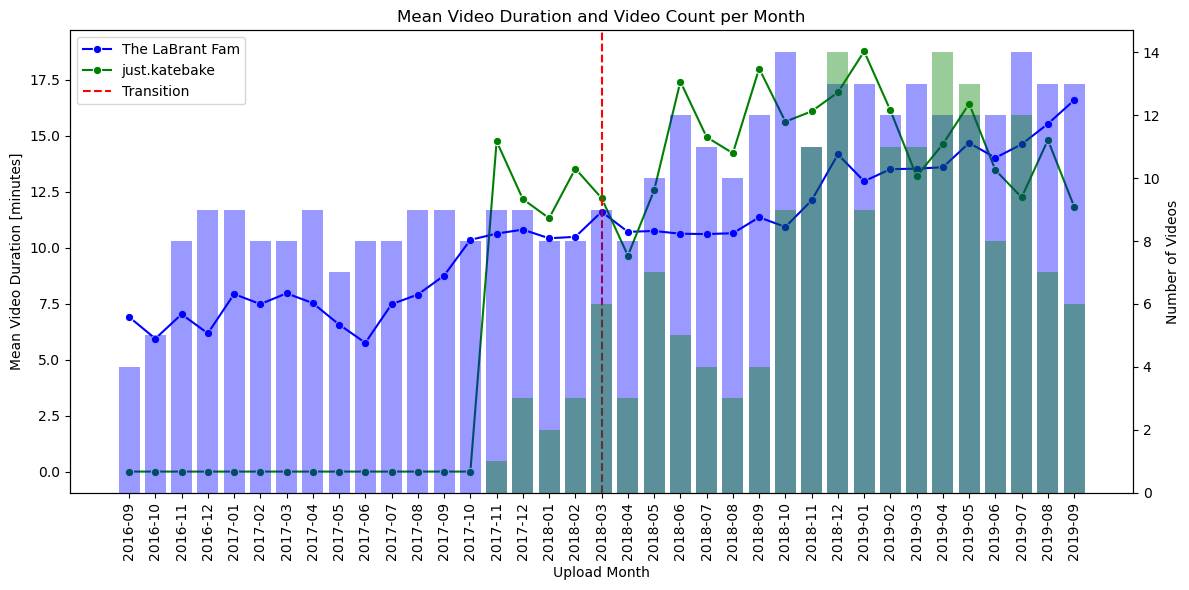

In [156]:
def video_frequency_and_duration(channel_ids, df_feather, channels, start_date=None, end_date=None, transition_date=None):
    """
    Plots the mean video duration per month for given channels, with an optional vertical line indicating a category transition
    Plot moreover a histogram of the number of videos published.

    Parameters:
    - channel_ids (list): List of YouTube channel IDs.
    - df_feather (DataFrame): DataFrame containing video data.
    - channels (DataFrame): DataFrame containing channel information.
    - start_date (str, optional): Start date for filtering videos.
    - end_date (str, optional): End date for filtering videos.
    - transition_date (str, optional): Date to draw a vertical line indicating the category transition.
    """
    
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()  # Primary axis 
    ax2 = ax1.twinx()  # Secondary axis 

    # Establish the full date range for x-axis
    start_period = pd.to_datetime(start_date).to_period('M') if start_date else df_feather['year_month'].min()
    end_period = pd.to_datetime(end_date).to_period('M') if end_date else df_feather['year_month'].max()
    full_period_range = pd.period_range(start=start_period, end=end_period, freq='M')
    
    colors = {channel_ids[0]: 'blue', channel_ids[1]: 'green'}
    alpha_level = 0.4  # Transparency for the bar plots

    for channel_id in channel_ids:
        df_filtered = df_feather[df_feather["channel_id"] == channel_id]

        mean_duration = df_filtered.groupby("year_month")["duration"].mean() / 60
        mean_duration = mean_duration.reindex(full_period_range, fill_value=0)
        channel_name = channels[channels["channel"] == channel_id]["name_cc"].values[0]
        sns.lineplot(ax=ax1, x=mean_duration.index.astype(str), y=mean_duration.values, marker="o", color=colors[channel_id], label=f"{channel_name}")

        video_count = df_filtered.groupby("year_month").size()
        video_count = video_count.reindex(full_period_range, fill_value=0)
        ax2.bar(video_count.index.astype(str), video_count.values, alpha=alpha_level, color=colors[channel_id])

    if transition_date:
        transition_period = pd.to_datetime(transition_date).to_period('M')
        ax1.axvline(x=str(transition_period), color='r', linestyle='--', label='Transition')

    ax1.set_xlabel("Upload Month")
    ax1.set_ylabel("Mean Video Duration [minutes]", color='black')
    ax2.set_ylabel("Number of Videos", color='black')
    ax1.tick_params(axis='y', colors='black')
    ax2.tick_params(axis='y', colors='black')
    x_ticks = range(len(full_period_range))
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels([period.strftime('%Y-%m') for period in full_period_range], rotation=90)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title("Mean Video Duration and Video Count per Month")
    plt.tight_layout()
    plt.show()

channel_ids = ['UC4-CH0epzZpD_ARhxCx6LaQ', 'UC0oRdyzTbGIZUISiGQnDdiw']
video_frequency_and_duration(channel_ids, df_feather, channels, start_date="2016-09", end_date="2019-09", transition_date="2018-03")

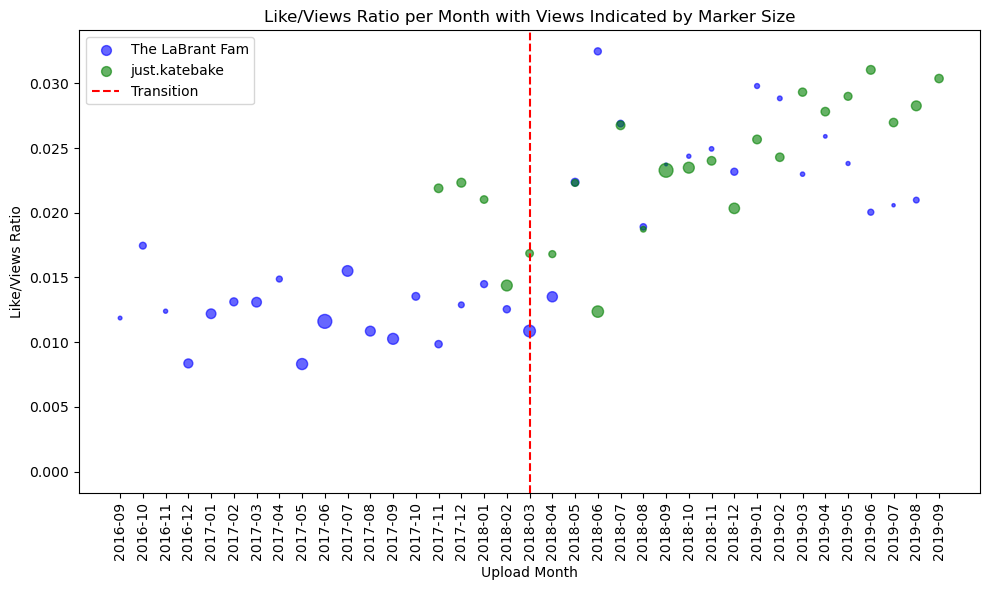

In [157]:
def video_likes_and_views(channel_ids, df_feather, channels, start_date=None, end_date=None, transition_date=None):
    """
    Plots the mean video likes and views per month for given channels, with an optional vertical line indicating the category transition.
    The y axis represents the number of likes per view ratio, ie have people liked a lot the videos after watching ? 
    Size of the marker corresponds to the total views, ie have people watched a lot this channel ? 

    Parameters:
    - channel_ids (list): List of YouTube channel IDs.
    - df_feather (DataFrame): DataFrame containing video data.
    - channels (DataFrame): DataFrame containing channel information.
    - start_date (str, optional): Start date for filtering videos.
    - end_date (str, optional): End date for filtering videos.
    - transition_date (str, optional): Date to draw a vertical line indicating the category transition
    """
    
    plt.figure(figsize=(10, 6))
    
    # Establish the full date range for x-axis
    start_period = pd.to_datetime(start_date).to_period('M') if start_date else df_feather['year_month'].min()
    end_period = pd.to_datetime(end_date).to_period('M') if end_date else df_feather['year_month'].max()
    full_period_range = pd.period_range(start=start_period, end=end_period, freq='M')
    
    colors = {channel_ids[0]: 'blue', channel_ids[1]: 'green'}
    for channel_id in channel_ids:
        df_filtered = df_feather[df_feather["channel_id"] == channel_id]
        df_filtered = df_filtered.groupby("year_month").agg({
            "like_count": "mean",
            "dislike_count" : "mean",
            "view_count": "mean"
        })

        # df_filtered["like_ratio"] = df_filtered["like_count"] / (df_filtered["like_count"] + df_filtered["dislike_count"]) # [like / (like + dislike)]
        df_filtered["like_over_views_ratio"] = df_filtered["like_count"] / df_filtered["view_count"]
        df_filtered = df_filtered.reindex(full_period_range, fill_value=0)
        
        # Normalize mean views to scale marker sizes
        scaled_marker_size = (df_filtered["view_count"] - df_filtered["view_count"].min()) / (df_filtered["view_count"].max() - df_filtered["view_count"].min()) * 100

        channel_name = channels[channels["channel"] == channel_id]["name_cc"].values[0]
        plt.scatter(df_filtered.index.astype(str), df_filtered["like_over_views_ratio"], s=scaled_marker_size, label=channel_name, alpha=0.6, color=colors[channel_id])
        

    if transition_date:
        plt.axvline(x=transition_date, color='r', linestyle='--', label='Transition')

    plt.xticks(rotation=90)
    plt.ylabel("Like/Views Ratio")
    plt.xlabel("Upload Month")
    plt.title("Like/Views Ratio per Month with Views Indicated by Marker Size")
    plt.legend()
    plt.tight_layout()
    plt.show()

channel_ids = ['UC4-CH0epzZpD_ARhxCx6LaQ', 'UC0oRdyzTbGIZUISiGQnDdiw']
video_likes_and_views(channel_ids, df_feather, channels, start_date="2016-09", end_date="2019-09", transition_date="2018-03")

# MAIN EDA COPY PASTE

# END

In [ ]:
df_non_na_like_rate = df_feather[df_feather["like_rate"].notnull()]

all_cc_mean_like_rate = df_non_na_like_rate.groupby("upload_year")["like_rate"].agg(["mean", "std"])
pb_mean_like_rate = df_non_na_like_rate[df_non_na_like_rate["categories"]==CATEGORY].groupby("upload_year")["like_rate"].agg(["mean", "std"])

plt.figure(figsize=(10, 6))
plt.errorbar(x=all_cc_mean_like_rate.index, y=all_cc_mean_like_rate["mean"], yerr=all_cc_mean_like_rate["std"], color="b", marker="o", markersize=10, label="All Categories")
plt.errorbar(x=pb_mean_like_rate.index, y=pb_mean_like_rate["mean"], yerr=pb_mean_like_rate["std"], color="g", marker="o", markersize=10, label="People & Blogs")
plt.xticks(rotation=45)
plt.ylabel("Mean Like/Dislike Ratio")
plt.xlabel("Upload Year")
plt.title("Mean Like Ratio per Year (2005-2019) for All Categories vs. People & Blogs")
plt.legend()
plt.show();

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
89,People & Blogs,2013-09-19,UCcgVECVN4OKV6DH1jLkqmcA,Jake Paul,19600000,824,144.0,2.087


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
2227359,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2016-10-10 00:00:00,1.153651e+07,1.707430e+05,3.146835e+05,0.000000,53,0,3
2227360,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2016-10-17 00:00:00,1.188670e+07,3.501910e+05,3.240289e+05,9345.375000,59,6,9
2227361,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2016-10-24 00:00:00,1.294078e+07,1.054077e+06,3.640662e+05,40037.375000,67,8,16
2227362,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2016-10-30 23:00:00,1.579009e+07,2.849306e+06,4.740138e+05,109947.532383,73,6,15
2227363,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2016-11-06 23:00:00,1.988030e+07,4.090208e+06,5.544423e+05,80428.476684,79,6,14
...,...,...,...,...,...,...,...,...,...,...
2227509,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2019-08-26 00:00:00,6.119198e+09,1.570312e+07,1.963949e+07,8929.875000,805,1,4
2227510,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2019-09-02 00:00:00,6.131083e+09,1.188426e+07,1.965240e+07,12902.375000,806,1,3
2227511,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2019-09-09 00:00:00,6.140796e+09,9.713263e+06,1.966730e+07,14898.875000,806,0,1
2227512,UCcgVECVN4OKV6DH1jLkqmcA,People & Blogs,2019-09-16 00:00:00,6.150118e+09,9.322378e+06,1.965598e+07,0.000000,808,2,3


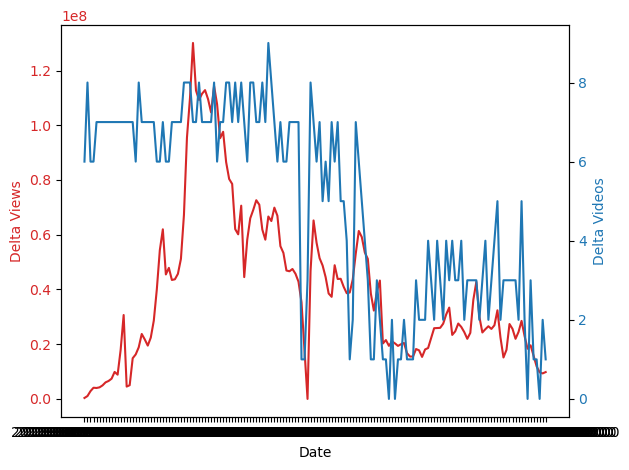

In [11]:
channel_id = 'UCcgVECVN4OKV6DH1jLkqmcA'
def plot_likes_and_views(channel_id, channels, timeseries, start_date = None, end_date = None):
    channel_info = channels[channels["channel"]==channel_id]
    display(channel_info)
    timeseries_filt = timeseries[timeseries["channel"] == channel_id]
    timeseries_filt.sort_values("datetime")
    display(timeseries_filt)

    timeseries_filt2 = timeseries_filt[1:].copy()
    if start_date is not None: 
        timeseries_filt2 = timeseries_filt[timeseries_filt['datetime'] >= start_date]
    if end_date is not None: 
        timeseries_filt2 = timeseries_filt2[timeseries_filt2['datetime'] >= end_date]

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Delta Views', color=color)
    ax1.plot(timeseries_filt2['datetime'], timeseries_filt2['delta_views'], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Delta Videos', color=color)  # we already handled the x-label with ax1
    ax2.plot(timeseries_filt2['datetime'], timeseries_filt2['delta_videos'], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

plot_likes_and_views(channel_id, channels_PB, timeseries_PB)

# 2nd milestone stuff

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import os 
# import pandas as pd
# import seaborn as sns
# import sys

In [132]:
# def category_evolution_of_channel_v0(channel_id, channels=channels_PB, df_feather=df_feather_PB):
#     '''
#     Input : a channel id, channels information dataframe and video metadata via df_feather
#     Output : annual count of number of videos of that channel in every category
#     Note : df_feather['upload_date'] should be already in datetime format
#     '''
#     # get info on the channel
#     # channel_info = channels[channels["channel"] == channel_id]
#     # display(channel_info)

#     df_feather_filt = df_feather[df_feather["channel_id"] == channel_id]
#     # For every year, count videos in each category
#     grouped_data = df_feather_filt[["year_month", "categories", "channel_id"]]
#     grouped_data = grouped_data.groupby(["year_month", "categories"]).count()
#     # Sort the values (need to transform in a regular dataframe and then put back indexes)
#     sorted_data = grouped_data.reset_index().sort_values(['year_month', 'channel_id'], ascending=[True, False])
#     sorted_data.set_index(['year_month', 'categories'], inplace=True)
#     # display(sorted_data)

#     # Select only the most popular category every year
#     most_popular_cat = sorted_data.reset_index().drop_duplicates(subset=["year_month"])
#     # display(most_popular_cat)

#     people_and_blog_proportion = len(most_popular_cat[most_popular_cat["categories"]=="People & Blogs"]) / len(most_popular_cat)
#     # print(people_and_blog_proportion)

#     return people_and_blog_proportion < 0.75

# # channel_id = 'UCcgVECVN4OKV6DH1jLkqmcA'
# # category_evolution_of_channel(channel_id)

In [ ]:
# NOTEBOOK_PATH = os.getcwd()
# DIR_PATH = os.path.dirname(NOTEBOOK_PATH)
# DATA_PATH = os.path.join(DIR_PATH, "data_youniverse")
# UTILS_PATH = os.path.join(DIR_PATH, "utils")
# CATEGORY = "Science & Technology"

# # append utils path and import utils
# sys.path.append(UTILS_PATH)
# from ploting import *
# from loading import *

In [ ]:
# df_channels_en = pd.read_csv(f"{DATA_PATH}/df_channels_en.tsv.gz", compression="infer", sep="\t") 
# # df_channels_en.head()

In [ ]:
# df_timeseries_en = pd.read_csv(f"{DATA_PATH}/df_timeseries_en.tsv.gz", compression="infer", sep="\t") # 20s
# # df_timeseries_en.head()

In [ ]:
# df_timeseries_en[df_timeseries_en['category'].isna()].channel.unique().size

In [ ]:
# df_channels_filt = df_channels_en[df_channels_en['category_cc'] == CATEGORY].copy()
# df_timeseries_filt = df_timeseries_en[df_timeseries_en['category'] == CATEGORY].copy()

In [ ]:
# helper_filt = read_and_filter_feather(f"{DATA_PATH}/yt_metadata_helper.feather", CATEGORY)
# helper_filt.head()

In [ ]:
# # UNCOMMENT IF NEEDED
# yt_metadata_filtered = load_and_filter_jsonl_gz_file_by_chunks(f"{DATA_PATH}/yt_metadata_en.jsonl.gz", CATEGORY) # 21m for pets and animals (should be the same for the other at it is reading all the file anyway)
# yt_metadata_filtered.to_csv(f"{DATA_PATH}/yt_metadata_pets&animals.csv.gz", index=False, compression="gzip") # stock the results
# yt_metadata_filtered.head()

In [ ]:
# yt_metadata_filtered.iloc[-1]['tags']

### Analysis of pets & animals category and tags

In [ ]:
# yt_metadata_filt = pd.read_csv(f"{DATA_PATH}/yt_metadata_pets&animals.csv.gz", compression="infer")
# # les channels id sont les vrai, ont peut retrouver les chaines youtube !

In [ ]:
# yt_metadata_filt['upload_date'] = pd.to_datetime(yt_metadata_filt['upload_date'])

In [ ]:
# yt_metadata_filt.describe()

### Plot the top 3 tags for a range of years

In [ ]:
# years = range(2016, 2020)  # or whatever years are applicable
# for year in years:
#     yt_metadata_filt_year = yt_metadata_filt[yt_metadata_filt['upload_date'].dt.year == year]
#     if not yt_metadata_filt_year.empty:
#         try:
#             # Assuming the function plot_topN_tag is correctly defined and can handle cases with less than N tags
#             plot_topN_tag(yt_metadata_filt_year['tags'], 3)
#         except Exception as e:
#             print(f"An error occurred for year {year}: {e}")
#     else:
#         print(f"No data available for year {year}")

### Cleaning of NaN values (not extensive)

In [ ]:
# def clean_dataframe(df):
#     # Remove rows where 'tags' is empty or NaN
#     initial_row_count = len(df)
#     df = df.dropna(subset=['tags'])  # Drops rows with NaN in 'tags'
#     df = df[df['tags'].str.strip().astype(bool)]  # Drops rows with empty 'tags'
#     cleaned_row_count = len(df)

#     # Check for NaN values in 'like_count'
#     like_count_nan = df['like_count'].isna().sum()
#     if like_count_nan > 0:
#         # Handle NaN values here. Options: fill with 0, mean, median, etc.
#         # Example: df['like_count'].fillna(df['like_count'].median(), inplace=True)
#         # For now, we'll just drop these rows
#         df = df.dropna(subset=['like_count'])

#     # Print out the cleaning summary
#     print(f"Rows with empty 'tags' removed: {initial_row_count - cleaned_row_count}")
#     print(f"Rows with NaN in 'like_count': {like_count_nan}")

#     return df

# # Clean the yt_metadata_filtered dataframe
# yt_metadata_filt_clean = clean_dataframe(yt_metadata_filt)

### Plot evolution of most popular tags

In [ ]:
# def get_top_tags_for_year(df, year, top_n=5):
#     """ Get the top N tags for a given year from the dataframe """
#     year_data = df[df['upload_date'].dt.year == year]
#     tag_list = year_data['tags'].str.split(',').explode()
#     top_tags = tag_list.value_counts().head(top_n).index
#     return top_tags

# def count_tag_appearances_by_year(df, tags):
#     """ Count the number of appearances of each tag by year """
#     df['year'] = df['upload_date'].dt.year
#     tag_counts_by_year = {tag: df[df['tags'].str.contains(tag)]['year'].value_counts().sort_index() for tag in tags}
#     return tag_counts_by_year

# def plot_tag_counts(tag_counts_by_year):
#     """ Plot the evolution of tag counts over the years """
#     plt.figure(figsize=(10, 8))
#     for tag, counts in tag_counts_by_year.items():
#         plt.plot(counts.index, counts.values, label=tag)
    
#     plt.xlabel('Year')
#     plt.ylabel('Number of Appearances')
#     plt.title('Evolution of Tag Appearances by Year')
#     plt.legend()
#     plt.show()

# top_tags_2019 = get_top_tags_for_year(yt_metadata_filt_clean, 2019)
# tag_counts_by_year = count_tag_appearances_by_year(yt_metadata_filt_clean, top_tags_2019)
# plot_tag_counts(tag_counts_by_year)

### Dataframe of statistics grouped by year

In [ ]:
# # Convert `upload_date` to DateTime and extract the year.
# yt_metadata_filt['upload_year'] = pd.to_datetime(yt_metadata_filt['upload_date']).dt.year

# # Group by the extracted year.
# grouped = yt_metadata_filt.groupby('upload_year')

# # Initialize a dictionary to hold aggregated data.
# aggregated_data = {}

# # Iterate over each group to perform aggregations.
# for name, group in grouped:
#     # Get the most popular tag for each year.
#     popular_tag = group['tags'].str.split(',').explode().value_counts().idxmax()
    
#     # Get other statistics for each year.
#     aggregated_data[name] = {
#         'most_popular_tag': popular_tag,
#         'total_like_count': group['like_count'].sum(),
#         'total_videos': group['upload_date'].count(),
#         'total_duration': group['duration'].sum(),
#         'unique_channels': group['channel_id'].nunique(),
#         'total_dislike_count': group['dislike_count'].sum(),
#         'total_view_count': group['view_count'].sum(),
#         'mean_dislike_count': group['dislike_count'].mean(),
#         'mean_like_count': group['like_count'].mean(),
#         'mean_duration': group['duration'].mean(),
#     }

# # Convert aggregated data to a DataFrame.
# stats_df = pd.DataFrame.from_dict(aggregated_data, orient='index')

# # Display the DataFrame
# stats_df.head(20)

### Plot evolution of metrics of previous dataframe

In [ ]:
# def plot_stats_over_years(df, columns):
#     """
#     Plots the evolution of specified columns from a DataFrame over the years.
    
#     Parameters:
#     - df: pandas DataFrame with a year index and columns to plot.
#     - columns: list of strings representing the column names to plot.
#     """
#     if not isinstance(columns, list):
#         columns = [columns]  # Convert to list if a single column name is passed.
        
#     for column in columns:
#         if column in df.columns:
#             plt.plot(df.index, df[column], label=column)
#         else:
#             print(f"Column '{column}' not found in the DataFrame.")
    
#     plt.xlabel('Year')
#     plt.ylabel('Value')
#     plt.title('Evolution of Statistics Over Years')
#     plt.legend()
#     plt.show()

# plot_stats_over_years(stats_df, ['total_like_count', 'total_dislike_count'])
# plot_stats_over_years(stats_df, ['mean_dislike_count', 'mean_like_count', 'mean_duration'])